<center><img src='../../img/ai4eo_logos.jpg' alt='Logos AI4EO MOOC' width='80%'></img></center>

<hr>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1280518"><< Back to FutureLearn</a><br>

# Training of a VGG16 Convolutional Neural Network in order to classify ships based on Sentinel-1 data

<i>by Leonardo De Laurentiis, University of Tor Vergata, Rome, Italy</i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/631902398?h=27546f33ba" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

<hr>

## Introduction

This notebook shows you how you can develop and train a Convolutional Neural Network (CNN) in order to classify ships extracted from Sentinel-1 data. A VGG16 Convolutional Neural Network model is trained with the help of the [OpenSARShip dataset](https://ieeexplore.ieee.org/document/8067489), which is a benchmark dataset to develop applicable and adaptive ship interpretation algorithms. The workflow makes use of a subset of the OpenSARShip dataset, using 2805 Sentinel-1 images each labelled as one of three ship classes:
* `0 - Bulk Carrier`
* `1 - Container Ship`
* `2 - Tanker`

## Machine-Learning Algorithm

The workflow develops and trains a VGG16 Convolutional Neural Network (ConvNet / CNN) model, which is a Deep Learning algorithm used to classify and detect features in an image. The model was proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper ['Deep Convolutional Networks for Large-Scale Image Recognition'](https://arxiv.org/abs/1409.1556). It is one of the simpler convolutional neural networks and makes only use of basic convolutions and pooling operations, but not network information, such as residual connections.
The number '16' stands for the layer depth of the network.

**Key Features of VGG16:**
* it is also called the `OxfordNet` model, named after the Visual Geometry Group from Oxford
* Number 16 refers to the fact that it has a total of 16 layers that have some weights
* uses always a 3x3 kernel for convolution
* it only has Conv and pooling layers

## Data

The workflow makes use of the data file [MOOC_dataset.npz](./MOOC_dataset.npz). The data file is a [.NPZ file](https://numpy.org/doc/stable/reference/generated/numpy.savez.html) which is a zipped archive of [.NPY files](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html#module-numpy.lib.format) and often used for Machine Learning applications, especially when multiple large images (numpy arrays) need to be saved in a compressed format.

The data file contains 2805 images with the size `128x128` pixels. Each image consists of an extracted ship from a Sentinel-1 image with VV-polarisation and each ship has an associated ship class label, indicating whether the ship in the image is a `0 - Bulk Carrier`, a `1 - Container Ship` or a `2 - Tanker`.

## Further resources

* [OpenSARShip: A Dataset Dedicated to Sentinel-1 Ship Interpretation](https://ieeexplore.ieee.org/document/8067489)
* [Merchant Vessel Ship Classification Based Scattering Component Analysis](https://ieeexplore.ieee.org/abstract/document/6451119)
* [Comprehensive guide to convolutional neural networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
* [Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

<hr>

## Notebook outline
* [1 - Inspect the labelled training data](#inspect)
* [2 - Instantiate the VGG16 model](#instantiate_vgg16)
* [3 - Instantiate a Keras model from input and output](#instantiate_keras)
* [4 - Configure the Keras model for training](#configure_training)
* [5 - Create training and test subsets from the data](#training_split)
* [6 - Optional: Train the model](#model_train)
* [7 - Load and evaluate the trained model](#load_evaluate)

<hr>

#### Import libraries

In [2]:
## BEGIN S3FS IMPORT SNIPPET ##
import os, sys
s3_home =  os.getcwd()
try: sys.path.remove(s3_home) # REMOVE THE S3 ROOT FROM THE $PATH
except Exception: pass

current_dir = os.getcwd()

os.chdir('/home/jovyan') # TEMPORARILY MOVE TO ANOTHER DIRECTORY

# BEGIN IMPORTS #

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

import numpy as np

from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

# END PYTHON IMPORTS #
os.chdir(current_dir) # GO BACK TO YOUR PREVIOUS DIRECTORY

sys.path.append(s3_home) # RESTORE THE S3 ROOT IN THE $PATH

## END S3FS IMPORT SNIPPET ##

<hr>

## <a id='inspect'></a>1. Inspect the labelled training data

The first step is to open the data file with the labelled training data to get a better understanding of the input data used for training the model. A `.npz` file can be opened with the `numpy.load()` function, which opens arrays stored in `.npy` and `.npz` files. The function returns a `NpzFile` object. With the function `.files()`, you can see an overview of the files that are part of the `.npz` file. 

You see that a set of two items are available: `image` and `label`.

<i>**Note:** Sentinel-1 images for this example only contain VV-polarisation</i>

In [3]:
data = np.load('./MOOC_dataset.npz') 
files = data.files 
files

['image', 'label']

<br>

In a next step, you can inspect the shape of the two items. The item `image` has a shape of [2805, 128, 128] and the item `label` is a one-dimensional array consisting of 2805 entries.

In [4]:
print('Shape - "Image" item: ' + str(data['image'].shape))
print('Shape - "Label" item: ' + str(data['label'].shape))

Shape - "Image" item: (2805, 128, 128)
Shape - "Label" item: (2805,)


<br>

You can also visualize one image with the function `plt.imshow()` and print the associated ship class from the `label` item. You can change the index number to see other image examples.

Ship class: 2


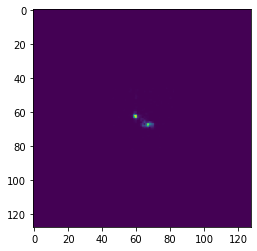

In [5]:
index = 2800
plt.imshow(data['image'][index,:,:])
print('Ship class: ' + str(data['label'][index]))

<br>

In a final step in inspecting the labelled training data, you can define the `image` item as input (`X`) and the `label` item as output (`y`) variables.

In [6]:
X = data['image']
y = data['label']

<br>

## <a id='instantiate_vgg16'></a>2. Instantiate the VGG16 model

The next step is to instantiate a Keras tensor that is used as an entry point for the network. You can use the `layers.Input` class from Python's Tensorflow Keras API `tf.keras`. Let us define a tensor with the size `128x128x1`. The size of the tensor relates to the size of the images used for training the model.

The output is a `KerasTensor` object called `inputs`.


In [7]:
inputs = tf.keras.layers.Input(shape=(128, 128, 1))
inputs

<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'input_1')>

<br>

Now we are able to instantiate the VGG16 model. The tensorflow Keras API offers under `tensorflow.keras.applications` a set of models (canned architectures) with pre-trained weights and `VGG16` is one of them. You can instantiate a VGG16 model with the following keyword arguments:

* `include_top=False` - we do not want to include the three fully-connected layers at the top of the network
* `weights=None` - by setting weights to None, we choose random initialization
* `input_tensor=inputs` - The input tensor is the inputs tensor created in the previous step
* `pooling='avg'` - global average pooling will be applied to the output of the last convolutional block and this means that the output of the model will be a two-dimensional tensor 

> **NOTE:**<br>
> `Fully connected layers`: By default, the algorithm would include three fully connected layers on top, but for training purposes, the example does not include them to give you an opportunity to play with hyperparameters in the next step.<br>
> `Pooling`: is a very common operation in CNNs and probably the most debated operation as well. Pooling reduces / condenses information by retrieving only the <code>min</code>, <code>max</code> or <code>avg</code> of a square block of information.<br>
> `weights`: this is a hyperparameter that can be changed. You can also choose a pre-trained set of weights based on RGB images. As the input images are different to RGB and only have one channel based on VV, it is recommended not to use the pre-trained weights.

<br>

In [8]:
vgg = VGG16(include_top=False,
            weights=None,
            input_tensor=inputs,
            pooling='avg')

vgg

From our instantiated model `vgg`, we can retrieve the input layer object with the function `input`. The resulting object is a tensor consisting of the input tensors of the model.

In [9]:
inp = vgg.input
inp

<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'input_1')>

<br>

In a next step, we add three fully-connected layers at the top of the network, in order to resemble the VGG16 architecture. The procedure is to define three `dense layers` and to add `dropout layers` in between. Dropout layers are introduced for regularisation purposes and to prevent overfitting. The procedure resembles a `stacking process` - this means, first, you build a `dense layer` followed by a `dropout layer` followed by a `dense layer` and so on. 

You can build a `dense layer` with the function `tf.keras.layers.Dense()` and a `dropout layer` with the function `tf.keras.layers.Dropout()`.

Interpretation of the code below:
* `dense1`: build a `dense layer` with 512 neurons on top of the `output of the vgg model` and use `relu` as activation function. `relu` stands for `Rectified Linear Unit`.
* `dropout1`: on top of dense layer `dense1`, add a dropout layer which randomly skips half (0.5) of the 512x128 (interconnections between dense layer 1 and denser layer 2) connections
* `dense2`: build another `dense layer` with 128 neurons on top of the dropout layer `dropout1` and use again `relu` (Rectified Linear Unit) as activation function
* `dropout2`: on top of dense layer `dense2`, add a dropout layer which randomly skips half (0.5) of the 128x3 (interconnections between dense layer 2 and dense layer 3) connections
* `pred`: build the final `dense layer` with 3 neurons on top of dropout layer `dropout2` and use the activation function `softmax`. The final number of neurons resembles the number of classes to predicat.

The dense layer `pred` is the expected output of our model. It is a `KerasTensor` with three neurons.

In [10]:
dense1 = tf.keras.layers.Dense(512, activation='relu')(vgg.output)
dropout1 = tf.keras.layers.Dropout(0.5)(dense1)

dense2 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

pred = tf.keras.layers.Dense(3, activation='softmax')(dropout2)
pred

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_2')>

<br>

## <a id='instantiate_keras'></a>3. Instantiate a Keras model from input and output

You now have your `VGG16 model` instantiated and on top, you added three fully-connected layers. With the KerasTensors `inp` and `pred`, you can now create the model with the function `tf.keras.Model()`. The function groups layers into an object with training and output features. The result is an untrained Neural Network, which you can configure for training in the next step.

In [11]:
model = tf.keras.Model(inp, pred)
model

<br>

Let us use the function `model.summary()` to inspect the architecture of the model. You see on top of the global average pooling layer the customized dense and dropout layers.

In [12]:
plot_model(model, to_file='./vgg.png', show_shapes=True)
print(model.summary())

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 1

<br>

## <a id='configure_training'></a>4. Configure the keras model for training

The next step is to configure the instantiated, but untrained Neural Network model. You can configure the model with `losses`, `optimizers` and `metrics` with the function `model.compile()`.

The function takes the following kwargs:
* `optimizer=tf.keras.optimizers.SGD()`
  * `SGD` stands for `Gradient descent optimizer`. It is a hyperparameter which can be changed. See all optimizer options [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
* `loss=tf.keras.losses.categorical_crossentropy`
  * `Cross-Entropy` loss is often used for multi-class classification. It means that the CNN is trained to output a probability for the specified classes for each image. It is usually combined with the activation function `softmax`.<br> 
* `metrics=['accuracy']`
  * metrics are used to judge the performance of your model. The `accuracy` metric calculates how often the predictions equal the given labels



In [13]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name='SGD')

model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model

<br>

## <a id='training_split'></a>5. Create training and testing subsets from the data

Let us now randomly split the training data into a `training subset` and a `testing subset`. Scikit-learn offers a popular function called `train_test_split()`, which creates four subsets based on the input and output variables `X - images` and `y - labels`. The function takes the following kwargs:

* `arrays`: input and output data arrays
* `test_size`: a float number representing the proportion of the dataset to include in the test subset
* `random_state`: An integer assuring reproducibility of the random shuffling of the data  

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

Check the dimensions of the training and test data subsets. The test data subset consists of 25% of the total original training data (n=2805).

In [15]:
print(X_train.shape)
print(X_test.shape)

(2103, 128, 128)
(702, 128, 128)


<br>

### <a id='convert_labels'></a>One-hot encoding of labels

`One-hot encoding` is a common way of preprocessing categorical features for Machine Learning. The labels are represented as class numbers ranging from 0 to 2. In the one-hot encoding process, the class numbers are converted to a (binary) bitwise representation in order to avoid the algorithm assuming any sort of instrinsic hierarchy or number order.

With the function `tf.keras.utils.to_categorical()`, you can convert the ship classes in a bitwise representation. You have to convert the labels for the training (`y_train`) and testing (`y_test`) subset respectively.

In [16]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)


<br>

## <a id='model_train'></a>*6. Optional: Train the model*

> **Note:** the next section is optional. Training of the model might take quite a long time. For convenience, you can also go to the [next section](#load_evaluate), where we continue by loading a pre-trained model.

Before you can train the model, it is best to define the required callbacks. Callbacks can be passed to Keras methods such as `model.fit()` in order to be able to analyse various stages of the training process.

Define the callback `ModelCheckpoint` with `tf.keras.callbacks.ModelCheckpoint()` in order to save the latest Keras model according to the model's validation accuracy.

In [17]:
check = tf.keras.callbacks.ModelCheckpoint('./vgg.h5',
                                           monitor='val_accuracy',
                                           verbose=0,
                                           save_best_only=True, mode='auto')

Define the callback `CSVLogger`, which saves the results of each epoch in a csv file with `tf.keras.callbacks.CSVLogger()`.

In [18]:
log = tf.keras.callbacks.CSVLogger('./vgg.txt')

<br>

With the defined callbacks above, you can now train (fit) the model with the function `model.fit()`, which takes the following keyword arguments:
* `input data`: training subset of input data - X_train
* `target_data`: training subset of expected output (labelled) data - y_train
* `batch_size`: integer specifying number of samples used per gradient update. Instead of the entire epoch, you only use a subset (batch) to update the network
* `epochs`: integer specifying the number of epochs. An epoch is one iteration of the entire x and y data provided.
* `validation_data`: data on which to evaluate the loss and any model metrics after each epoch.
* `callbacks`: list of Keras callbacks to be applied during the training 

> **Note:**<br>
The training model did only go through 2 epoch cycles, which is quite low. In general, it would be good to train the model on at least 150 epochs (training cycles). As one iteration can take quite long, it is recommend to conduct this operation on a machine with Graphics Processing Unit (GPU).

In [19]:
import multiprocessing
from timeit import default_timer as timer

start = timer()
cpu_count = multiprocessing.cpu_count()
print(f"cpu: {cpu_count} found")

model.fit(X_train, y_train,
          batch_size=12,
          epochs=2,
#          epochs=150,
          verbose=1,
          validation_data=(X_test, y_test),
          steps_per_epoch = 25,
          max_queue_size=10,
          workers=cpu_count,
          use_multiprocessing=cpu_count > 1,
          callbacks=[check, log])

end = timer()
print('Elapsed time: ' + str(end - start))

cpu: 8 found
Epoch 1/2
25/25 [==============================] - 98s 4s/step - loss: 1.0986 - accuracy: 0.3841 - val_loss: 1.0963 - val_accuracy: 0.4017
Epoch 2/2
25/25 [==============================] - 95s 4s/step - loss: 1.0929 - accuracy: 0.4530 - val_loss: 1.0921 - val_accuracy: 0.4017
Elapsed time: 196.16200350224972


<br>

## <a id='load_evaluate'></a>7. Load and evaluate the trained model

You can use the function `load_model` from `tf.keras.model` to load the pre-trained model `vgg.h5`. The function `model.evaluate()` lets you evaluate the performance of the trained model with the testing subsets of `input` and `target` data. It returns the frequency of how often the predicted values have matched the test values.

In [20]:
model = load_model('./vgg.h5')

_, test_acc = model.evaluate(X_test, y_test)

print('Test_acc: %.4f' % test_acc)

22/22 [==============================] - 31s 1s/step - loss: 1.0963 - accuracy: 0.4017
Test_acc: 0.4017


<br>

In a next step, you can apply the function `model.predict()` to predict a ship class with the help of the trained model. You provide the function an input array from the test dataset (`X_test`). The result is a probability vector, indicating for each ship class the probability. The highest probability is the predicted class. Feel free to change the index in order to get a better feeling of the robustness of the trained model.

In [21]:
class_names = ['Bulk Carrier', 'Container Ship', 'Tanker']

In [22]:
index = 50
pred = model.predict(np.array([X_test[index]]))
print(pred)

[[0.3412053  0.3278484  0.33094627]]


<br>

In a last step, based on the probability vector above, you can compare the predicted class (`np.argmax(pred)`) against the actual class of a given input image (`np.argmax(y_test[])`).

In [23]:
print('Class to predict: ' + class_names[np.argmax(y_test[index])])
print('Predicted with label: ' +class_names[np.argmax(pred)])


Class to predict: Bulk Carrier
Predicted with label: Bulk Carrier


<br>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1171726"><< Back to FutureLearn</a><br>

<hr>

<img src='../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for [EUMETSAT](https://www.eumetsat.int/), [ECMWF](https://www.ecmwf.int/) and [Mercator Ocean International](https://www.mercator-ocean.fr/en/) in support of the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and the [WEkEO platform](https://wekeo.eu/).
